In [1]:
import hashlib 
from pathlib import Path
from typing import Iterable, List, Dict, Tuple, Set
from collections import defaultdict, Counter
from functools import lru_cache
from copy import deepcopy

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from crowdkit.aggregation import ROVER
from tqdm.auto import tqdm


def edit_distance(ref: Iterable, hyp: Iterable) -> int:
    """
    dynamic programming levenshtein implementation O(n^2)
    """
    
    dist = np.zeros((len(hyp) + 1, len(ref) + 1), dtype=np.int32)
    
    dist[:, 0] = np.arange(len(hyp) + 1)
    dist[0, :] = np.arange(len(ref) + 1)

    for i, r in enumerate(hyp, start=1):
        for j, h in enumerate(ref, start=1):
            dist[i, j] = min(
                dist[i - 1, j - 1] + (r != h),
                dist[i, j - 1] + 1,
                dist[i - 1, j] + 1
            )
            
    return dist[-1, -1]


def error_rate(refs: Iterable[Iterable], hyps: Iterable[Iterable]) -> float:
    """
    ignoring hypotheses with empty references
    """
    
    wrong_words, all_words = 0, 0
    
    for ref, hyp in zip(refs, hyps):
        if len(ref) > 0:
            wrong_words += edit_distance(ref, hyp)
            all_words += len(ref)
        else:
            continue
    return wrong_words / all_words


def wer(refs: Iterable[str], hyps: Iterable[str]) -> float:
    """
    Word Error Rate
    """
    return error_rate(
        [ref.split() for ref in refs],
        [hyp.split() for hyp in hyps]
    )

bad file: maratgasanov


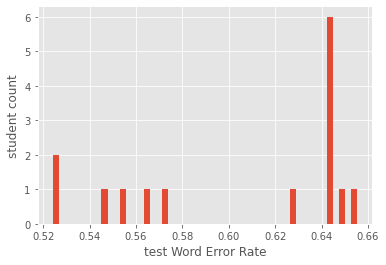

,name,WER
0,Коленков,0.524106
1,Ермаков,0.524337
2,Khazhiev.json,0.546814
3,Popov,0.553845
4,Gamarnik,0.564365
5,Ivan_Malakhov,0.571524
6,Кежаев,0.627024
7,Kashurin,0.644036
8,Ustsov,0.644036
9,Safonov,0.644036


In [2]:
prefix = "noisy_text_aggregation_test_prediction_"

student2prediction_df = {
    path.stem[len(prefix):]: pd.read_json(path, lines=True)
    for path in Path("student_works").iterdir()
}

answer_df = pd.read_json("noisy_text_aggregation_test_answer.jsonl", lines=True)

student2wer = {}

for student, df in student2prediction_df.items():
    try:
        merged_df = pd.merge(df, answer_df, on='task')
        student2wer[student] = wer(merged_df['text'], merged_df['prediction'])
    except:
        print(f'bad file: {student}')
        
plt.hist(student2wer.values(), bins=50)
plt.xlabel("test Word Error Rate")
plt.ylabel("student count")
plt.show()

results = (
    pd.DataFrame(student2wer.items(), columns=['name', 'WER'])
    .sort_values("WER")
    .reset_index(drop=True)
)

results

# Solution

In [3]:
def hash_remainder(str_, base: int=10) -> int:
    return int(hashlib.md5(str_.encode()).hexdigest(), 16) % base

train_df = pd.read_json("./noisy_text_aggregation_train.jsonl", lines=True)

train_mask = train_df['task'].apply(lambda x: hash_remainder(x, 10) <= 7)

val_df = train_df[~train_mask].reset_index(drop=True)
train_df = train_df[train_mask].reset_index(drop=True)

## ROVER

Recognizer Output Voting Error Reduction

In [4]:
base_rover = ROVER(
    tokenizer=lambda x: list(x),
    detokenizer=lambda x: "".join(x)
)

In [5]:
hyps = ['игорем ивановичем гусевым', 'игарем ивановичем гусивым', 'игре ивановича гусевам']

In [6]:
wtn = base_rover._build_word_transition_network(hyps)

In [7]:
def print_wtn(wtn: dict) -> None:
    result = ''
    for node in wtn:
        if len(node) == 1:
            print(next(iter(node.keys())), end='')
        else:
            print(
                "(" + ",".join([f"{k}:{v.sources_count}" for k,v in node.items()]) + ")"
                ,
                end=''
            )


print_wtn(wtn)

иг(о:1,а:1,:1)ре(м:2,:1) иванович(е:2,:1)(м:2,а:1) гус(е:2,и:1)в(ы:2,а:1)м

In [8]:
base_rover.detokenizer(
    base_rover._get_result(wtn)
)

'игорем ивановичем гусевым'

In [9]:
printed = 0

for id_ in range(100):
    weak_order = ['qnet', 'w2v_tts', 'w2v']
    strong_order = ['w2v', 'w2v_tts', 'qnet']
    
    weak_wtn = base_rover._build_word_transition_network(train_df[weak_order].values[id_])
    strong_wtn = base_rover._build_word_transition_network(train_df[strong_order].values[id_])
    
    weak_result = base_rover.detokenizer(base_rover._get_result(weak_wtn))
    strong_result = base_rover.detokenizer(base_rover._get_result(strong_wtn))
    
    if weak_result != strong_result:
        print(f"weak  : {weak_result}")
        print(f"strong: {strong_result}")
        print(f"true  : {train_df['text'].values[id_]}")
        print("#" * 50)
        printed += 1
    if printed == 10:
        break

weak  : александро игрривиче корнеева
strong: александро игрривича корнеева
true  : александра игоревича корнеева
##################################################
weak  : виталия
strong: виталя
true  : виталя
##################################################
weak  : светлание федоров немомедовай
strong: светлане федоров немомедовай
true  : светлане федоровне мамедовой
##################################################
weak  : на тальи лионтивой
strong: на тальи лионьивой
true  : натальи леонтьевой
##################################################
weak  : солтаны хосановича белога
strong: солтана хосановича белога
true  : солтана хасановича белова
##################################################
weak  : озайцы вым
strong: пзайцы вым
true  : зайцевым
##################################################
weak  : алочку александрогу
strong: алочку александрову
true  : аллочку александрову
##################################################
weak  : сера мосщеткави
strong: сера осщеткави
t

In [10]:
class PriorityROVER(ROVER):
    
    def fit(self, data):
        """
        Fits the model. The aggregated results are saved to the `texts_` attribute.
        """

        result = {}
        grouped_tasks = data.groupby('task') if self.silent else tqdm(data.groupby('task'))
        for task, df in grouped_tasks:
            
            df.sort_values("priority", inplace=True) # !!!
            
            hypotheses = [self.tokenizer(text) for i, text in enumerate(df['text'])]

            edges = self._build_word_transition_network(hypotheses)
            rover_result = self._get_result(edges)

            text = self.detokenizer([value for value in rover_result if value != ''])

            result[task] = text

        result = pd.Series(result, name='text')
        result.index.name = 'task'
        self.texts_ = result
        return 

In [11]:
def get_rover_df(df: pd.DataFrame, model_cols: List[str], tmp_col: str="__tmp") -> pd.DataFrame:

    rover_df = df.copy()
    
    if "text" in rover_df.columns:
        rover_df.drop("text", axis=1, inplace=True)
    
    rover_df[tmp_col] = rover_df.apply(lambda row: [(model, row[model]) for model in model_cols], axis=1)
    
    rover_df = rover_df.drop(model_cols, axis=1).explode(tmp_col)

    return pd.DataFrame({
        "task": rover_df["task"],
        "performer": rover_df[tmp_col].apply(lambda x: x[0]),
        "text": rover_df[tmp_col].apply(lambda x: x[1])
    })

In [12]:
MODELS = ['qnet', 'w2v_tts', 'w2v']

method2wer = {model: wer(val_df['text'], val_df[model]) for model in MODELS}

method2wer

{'qnet': 0.9486507626124364,
 'w2v_tts': 0.7106374657802111,
 'w2v': 0.6546343371138053}

In [13]:
model2priority = {
    'w2v': 1,
    'w2v_tts': 2,
    'qnet': 3
}

rover_df = get_rover_df(val_df, model_cols=MODELS)

rover_df['priority'] = rover_df['performer'].apply(lambda x: model2priority[x])

In [14]:
tokenizer = lambda x: list(x)
detokenizer = lambda x: "".join(x)

priority_rover_df = (
    PriorityROVER(tokenizer=tokenizer, detokenizer=detokenizer, silent=False)
    .fit_predict(rover_df)
)

base_rover_df = (
    ROVER(tokenizer=tokenizer, detokenizer=detokenizer, silent=False)
    .fit_predict(rover_df)
)

In [15]:
for df, method in [(base_rover_df, 'base_ROVER'), (priority_rover_df, 'priority_ROVER')]:

    merged_df = pd.merge(df.reset_index(), val_df, on='task')
    wer_metric = wer(merged_df['text'], merged_df['agg_text'])
    method2wer[method] = wer_metric    

In [16]:
method2wer

{'qnet': 0.9486507626124364,
 'w2v_tts': 0.7106374657802111,
 'w2v': 0.6546343371138053,
 'base_ROVER': 0.6477121626906531,
 'priority_ROVER': 0.6387172467735628}

## Rescoring

In [17]:
text_data = pd.read_csv("noisy_text_aggregation_text_only.csv", header=None)

In [18]:
def build_ngram_counts(
        tokenized_texts: Iterable[Iterable[str]], 
        n: int,
        BOS: str,
        EOS: str
    ) -> Dict[Tuple[str, ...], Dict[str, int]]:
        
        counts = defaultdict(Counter)

        for text in tokenized_texts:

            ngrams = nltk.ngrams(
                text, n=n, pad_left=True, pad_right=True, left_pad_symbol=BOS, right_pad_symbol=EOS
            )

            for ngram in ngrams:
                prev, token = ngram[:-1], ngram[-1]
                counts[prev][token] += 1

        return counts


class LaplaceLanguageModel:
    
    def __init__(
            self,
            ngram_counts: Dict[Tuple[str, ...], Dict[str, int]],
            n: int, 
            delta: float = 0.0, 
            BOS: str='<BOS>',
            EOS: str='<EOS>'
        ):
        self.n = n
        self.BOS = BOS
        self.EOS = EOS
        
        self.vocab = {
            token for distribution in ngram_counts.values() for token in distribution
        }
        
        self.probs = defaultdict(Counter)

        for prefix, distribution in ngram_counts.items():
            norm: float = sum(distribution.values()) + delta * len(self.vocab)
            self.probs[prefix] = {
                token: (count + delta) / norm for token, count in distribution.items()
            }
    
    def __get_observed_token_distribution(self, prefix: List[str]) -> Dict[str, float]:
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [self.BOS] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]
    
    
    def get_token_distribution(self, prefix: List[str]) -> Dict[str, float]:
        
        distribution: Dict[str, float] = self.__get_observed_token_distribution(prefix)
        
        missing_prob_total: float = 1.0 - sum(distribution.values())
        
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(distribution))
        
        return {token: distribution.get(token, missing_prob) for token in self.vocab}
    
    
    def get_next_token_prob(self, prefix: List[str], next_token: str):
        
        distribution: Dict[str, float] = self.__get_observed_token_distribution(prefix)
        
        if next_token in distribution:
            return distribution[next_token]
        
        else:
            missing_prob_total = 1.0 - sum(distribution.values())
            return max(0, missing_prob_total) / max(1, len(self.vocab) - len(distribution))
    
    
    def score_sequence(self, tokens: List[str], min_logprob: float = np.log(10 ** -50.)) -> float:
        prefix = [self.BOS] * (self.n - 1)
        padded_tokens = tokens + [self.EOS]
        logprobs_sum = 0.0
        for token in padded_tokens:
            logprob = np.log(self.get_next_token_prob(prefix, token))
            prefix = prefix[1:] + [token]
            logprobs_sum += max(logprob, min_logprob)
        return logprobs_sum / len(tokens) if tokens else 0.0

In [19]:
orders = (2, 3, 4, 5, 6, 7, 8, 9, 10)
smoothing = (0.9, 0.7, 0.5, 0.3, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4)

wers = np.zeros(shape=(len(orders), len(smoothing)))

BOS = '<BOS>'
EOS = '<EOS>'

for i, order in enumerate(orders):
    
    ngram_counts = build_ngram_counts(tokenized_texts=text_data[0], n=order, BOS=BOS, EOS=EOS)
    
    for j, delta in enumerate(smoothing):
        lm = LaplaceLanguageModel(
            n=order,
            ngram_counts=ngram_counts,
            delta=delta,
            BOS=BOS,
            EOS=EOS
        )
        
        scoring_result = train_df.apply(
            lambda row: row[
                MODELS[
                    np.array([
                        lm.score_sequence(tokens=list(row[model])) for model in MODELS
                    ]).argmax()
                ]
            ], 
            axis=1
        )
        
        wers[i, j] = wer(train_df.text, scoring_result)

/var/folders/1w/55f2466j79335k2064k2wj480000gn/T/ipykernel_39414/2842891102.py:83: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.get_next_token_prob(prefix, token))


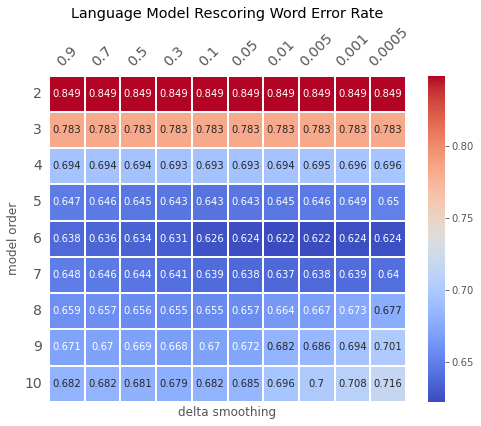

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(
    pd.DataFrame(
        wers,
        index=orders,
        columns=smoothing
    ),
    annot=True,
    fmt='.3g',
    cmap='coolwarm',
    linewidth=2
)
plt.title("Language Model Rescoring Word Error Rate")
plt.tick_params(
    axis='both', which='major', labelsize=14, left=False, labelbottom=False, 
    bottom=False, top=False, labeltop=True
)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.ylabel("model order")
plt.xlabel("delta smoothing")
plt.show()

In [21]:
n = 6
delta = 1e-2

ngram_counts = build_ngram_counts(tokenized_texts=text_data[0], n=n, BOS=BOS, EOS=EOS)

lm = LaplaceLanguageModel(
    n=n, delta=delta, BOS=BOS, EOS=EOS,
    ngram_counts=ngram_counts
)

scoring_result = val_df.apply(
    lambda row: row[
        MODELS[
            np.array([
                lm.score_sequence(tokens=list(row[model])) for model in MODELS
            ]).argmax()
        ]
    ], 
    axis=1
)

In [22]:
method2wer["6_gram_1e-2_rescoring"] = wer(val_df.text, scoring_result)

In [23]:
method2wer

{'qnet': 0.9486507626124364,
 'w2v_tts': 0.7106374657802111,
 'w2v': 0.6546343371138053,
 'base_ROVER': 0.6477121626906531,
 'priority_ROVER': 0.6387172467735628,
 '6_gram_1e-2_rescoring': 0.6325381306218224}

In [24]:
models = ['w2v', 'w2v_tts']

scoring_result = val_df.apply(
    lambda row: row[
        models[
            np.array([
                lm.score_sequence(tokens=list(row[model])) for model in models
            ]).argmax()
        ]
    ],
    axis=1
)

In [25]:
method2wer['6_gram_1e-2_rescoring_without_qnet'] = wer(val_df['text'], scoring_result)

## LM + ROVER

In [26]:
class LmROVER(ROVER):
    
    def __init__(self, lm, print_hyps=False, max_uncertainity_nodes=4, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lm = lm
        self.max_uncertainity_nodes = max_uncertainity_nodes
        self.print_hyps = print_hyps

    def fit(self, data):
        """
        Fits the model. The aggregated results are saved to the `texts_` attribute.
        """

        result = {}
        grouped_tasks = data.groupby('task') if self.silent else tqdm(data.groupby('task'))
        for task, df in grouped_tasks:
            
            df.sort_values("priority", inplace=True) # !!!
            
            hypotheses = [self.tokenizer(text) for i, text in enumerate(df['text'])]

            edges = self._build_word_transition_network(hypotheses)
            rover_result = self._get_result(edges)

            text = self.detokenizer([value for value in rover_result if value != ''])

            result[task] = text

        result = pd.Series(result, name='text')
        result.index.name = 'task'
        self.texts_ = result
        return
    
    def _get_result(self, edges) -> List[str]:
        results = [[]]
        
        uncertainity_nodes_count = sum(
            len({x.sources_count for x in edges_set.values()}) == 1 and len(edges_set.values()) > 1
            for edges_set in edges
        )
        
        if uncertainity_nodes_count > self.max_uncertainity_nodes:
            return super()._get_result(edges)
        
        for edges_set in edges:
            
            e_values = edges_set.values()
            
            unique_counts = len({x.sources_count for x in e_values})
            
            if len(e_values) > 1 and unique_counts == 1:
                new_results = []
                for x in e_values:
                    for result in results:
                        new_results.append(result + [x.value])
                results = deepcopy(new_results)
            else:
                _, value = max((x.sources_count, x.value) for x in e_values)
                for result in results:
                    result.append(value)
        
        candidates = [
            (self.lm.score_sequence(list(self.detokenizer(result))), result)
            for result in results
        ]
        
        if self.print_hyps and len(candidates) > 1:
            
            candidates = sorted(candidates)[::-1]
            
            print("#" * 64)
            for score, sequence in candidates:
                print(
                    f"{score:.3f} \t {self.detokenizer(sequence)}"
                )
                
            best_score, best_result = candidates[0]
        else:
            best_score, best_result = max(candidates)
        
        return best_result

In [27]:
_ = (
    LmROVER(lm, tokenizer=tokenizer, detokenizer=detokenizer, print_hyps=True)
    .fit_predict(rover_df.head(100 * 3))
)

################################################################
-2.437 	 анжелкойивелисеевой
-2.452 	 анжелкойилелисеевой
-2.596 	 анжелкойилерлисеевой
-2.609 	 анжелкойиделисеевой
-2.732 	 анжелкойилееисеевой
-2.732 	 анжелкойидееисеевой
-2.732 	 анжелкойивееисеевой
-2.760 	 анжелкопивелисеевой
-2.772 	 анжелкойиве еисеевой
-2.783 	 анжелкойиверлисеевой
-2.786 	 анжелко ивелисеевой
-2.797 	 анжелкопиделисеевой
-2.837 	 анжелко илелисеевой
-2.840 	 анжелкойидереисеевой
-2.886 	 анжелкойиде еисеевой
-2.906 	 анжелкойилерисеевой
-2.921 	 анжелкопидееисеевой
-2.938 	 анжелкойиле еисеевой
-2.946 	 анжелкопилелисеевой
-2.947 	 анжелкойилеррисеевой
-2.955 	 анжелкойиверисеевой
-2.961 	 анжелко илерлисеевой
-2.966 	 анжелкойидерисеевой
-2.979 	 анжелко иделисеевой
-2.994 	 анжелкойилереисеевой
-2.994 	 анжелкойивереисеевой
-3.006 	 анжелкойиве рисеевой
-3.006 	 анжелкойидерлисеевой
-3.008 	 анжелко ивееисеевой
-3.016 	 анжелкойиверрисеевой
-3.019 	 анжелкопидереисеевой
-3.034 	 анжелко иве е

In [28]:
lm_rover_df = (
    LmROVER(lm, tokenizer=tokenizer, detokenizer=detokenizer, silent=False)
    .fit_predict(rover_df)
)

In [29]:
merged_df = pd.merge(lm_rover_df.reset_index(), val_df, on='task')

method2wer['lm_ROVER'] = wer(merged_df['text'], merged_df['agg_text'])

In [30]:
method2wer

{'qnet': 0.9486507626124364,
 'w2v_tts': 0.7106374657802111,
 'w2v': 0.6546343371138053,
 'base_ROVER': 0.6477121626906531,
 'priority_ROVER': 0.6387172467735628,
 '6_gram_1e-2_rescoring': 0.6325381306218224,
 '6_gram_1e-2_rescoring_without_qnet': 0.6063746578021119,
 'lm_ROVER': 0.6275713727023856}

## Error Correction

In [31]:
def one_edit_words(word: str) -> Set[str]:
    """
    return list of candidates with one correction
    """
    letters = 'абвгдежзийклмнопрстуфхцчшщъыьэюя'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletions = [left + right[1:] for left, right in splits if right]
    substitutions = [left + c + right[1:] for left, right in splits if right for c in letters]
    insertions = [left + c + right for left, right in splits for c in letters]
    return set(deletions + substitutions + insertions)


word_counts = Counter([word for utterance in train_df['text'].str.split() for word in utterance])


@lru_cache(maxsize=None)
def correct_word(word: str) -> str:
    if word in word_counts:
        return word
    
    candidates = one_edit_words(word)
    
    candidates = sorted([
            (word, word_counts[word])
            for word in candidates if word_counts[word] > 0
        ],
        key=lambda x: -x[1]
    )
    
    if candidates:
        return max(candidates, key=lambda x: x[1])[0]
    return word

In [32]:
for model in MODELS:
    
    method = f"{model}_corrected"
    val_df[method] = val_df[model].apply(
        lambda x: " ".join([correct_word(w) for w in x.split()])
    )
    
    method2wer[method] = wer(val_df['text'], val_df[method])

In [33]:
corrected_models = ["w2v_tts_corrected", "w2v_corrected"]

val_df['rescored_corrected_w2vs'] = val_df.apply(
    lambda row: row[
        corrected_models[
            np.array([
                lm.score_sequence(tokens=list(row[model])) for model in corrected_models
            ]).argmax()
        ]
    ],
    axis=1
)

In [34]:
method2wer['6_gram_1e-2_rescoring_corrected_without_qnet'] = wer(
    val_df['text'], val_df['rescored_corrected_w2vs']
)

In [35]:
method2wer

{'qnet': 0.9486507626124364,
 'w2v_tts': 0.7106374657802111,
 'w2v': 0.6546343371138053,
 'base_ROVER': 0.6477121626906531,
 'priority_ROVER': 0.6387172467735628,
 '6_gram_1e-2_rescoring': 0.6325381306218224,
 '6_gram_1e-2_rescoring_without_qnet': 0.6063746578021119,
 'lm_ROVER': 0.6275713727023856,
 'qnet_corrected': 0.8360187719984357,
 'w2v_tts_corrected': 0.5676183026984748,
 'w2v_corrected': 0.5412983965584669,
 '6_gram_1e-2_rescoring_corrected_without_qnet': 0.4999217833398514}

# Test Prediction

In [36]:
test_df = pd.read_json("noisy_text_aggregation_test.jsonl", lines=True)

In [37]:
models = ['w2v', 'w2v_tts']

for model in models:
    test_df[f"{model}_corrected"] = test_df[model].apply(
        lambda x:  " ".join([correct_word(w) for w in x.split()])
    )

corrected_models = [f"{model}_corrected" for model in models]    

test_df['prediction'] = test_df.apply(
    lambda row: row[
        corrected_models[
            np.array([
                lm.score_sequence(tokens=list(row[model])) for model in corrected_models
            ]).argmax()
        ]
    ],
    axis=1
)

In [38]:
merged_df = pd.merge(test_df, answer_df, on='task')

In [39]:
wer(merged_df['text'], merged_df['prediction'])

0.4980884201883355